# Computer Vision Generator
---

> Konstantinos Mpouros <br>
> Github: https://github.com/konstantinosmpouros <br>
> Year: 2023 <br>

## 1. About the project

The **Computer Vision Generator** project is designed to explore the capabilities of large language models (LLMs) in the field of image and video generation. The goal of this notebook (**Image Refiner**) is to create a script that refines the image either by adding something in it or by manipulating it and creating a new image similar to first. This process will be conducted with the use of pretrained models for image processing from [huggingface](https://huggingface.co/), torch and more.

By leveraging the power of LLMs, specifically trained for image synthesis, the script interprets natural language prompts and translates them into detailed, accurate images. This project showcases the potential of AI to bridge the gap between language and vision, enabling the seamless conversion of ideas into visuals. The use cases for such a system are vast, ranging from creative arts and media production to education and design. By automating the process of image creation based on descriptions, the **Computer Vision Generator** opens up new possibilities for users to bring their ideas to life quickly and efficiently.

## 2. Libraries

In [1]:
# Image retrieval, manipulation and presentation
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision.transforms import functional as F

# Pytorch
import torch

# Binary Mask Generation
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from torchvision.models.detection import maskrcnn_resnet50_fpn

# Image Upscaler
from aura_sr import AuraSR

# Image Inpainting
from diffusers import AutoPipelineForInpainting, DEISMultistepScheduler

2024-10-29 20:05:12.359197: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 20:05:12.366328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 20:05:12.374409: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 20:05:12.377213: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 20:05:12.384182: I tensorflow/core/platform/cpu_feature_guar

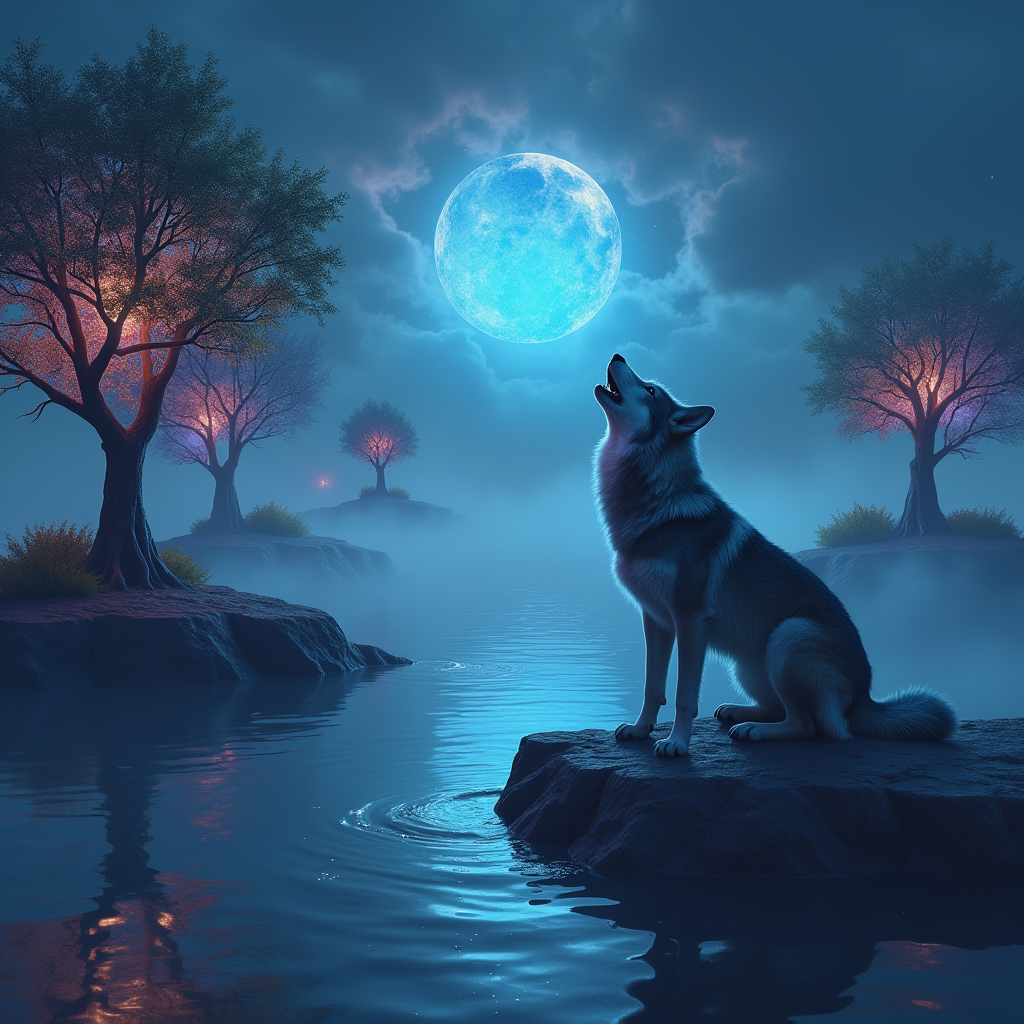

In [2]:
image_name = 'Dreamscape_wolf_4'
image_path = 'Image Generation/FLUX.1/' + image_name + '.png'
init_image = Image.open(image_path)
init_image

In [3]:
def count_files(path):
    # List all files in the directory
    files = os.listdir(path)
    max_number = 0

    # Filter for files that have a .png extension and start with a number
    image_files = [f for f in files if f.endswith('.png')]

    if image_files:
        max_number = len(image_files)

    return max_number

In [4]:
def check_image_existance(path, image_name):
    path = path + image_name + '.png'

    # Check if the path exists
    if os.path.exists(path):
        return False
    else:
        return True

## 3. Image Binary Mask Generation

### 3.1 Detectron2

In [5]:
image = cv2.imread(image_path)

In [6]:
# Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.65  # Set threshold for this model
cfg.MODEL.EVAL_PERIOD = 10
predictor = DefaultPredictor(cfg)

In [7]:
# Run inference
outputs = predictor(image)

# Get the masks
masks = outputs["instances"].pred_masks.cpu().numpy()

# Create binary mask by combining all masks
binary_mask = np.zeros(image.shape[:2], dtype=np.uint8)
for mask in masks:
    binary_mask = np.maximum(binary_mask, mask.astype(np.uint8))
binary_mask = binary_mask * 255 

# Optionally visualize full output
v = Visualizer(image[:, :, ::-1], metadata={}, scale=1)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

/home/kostasbouros/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


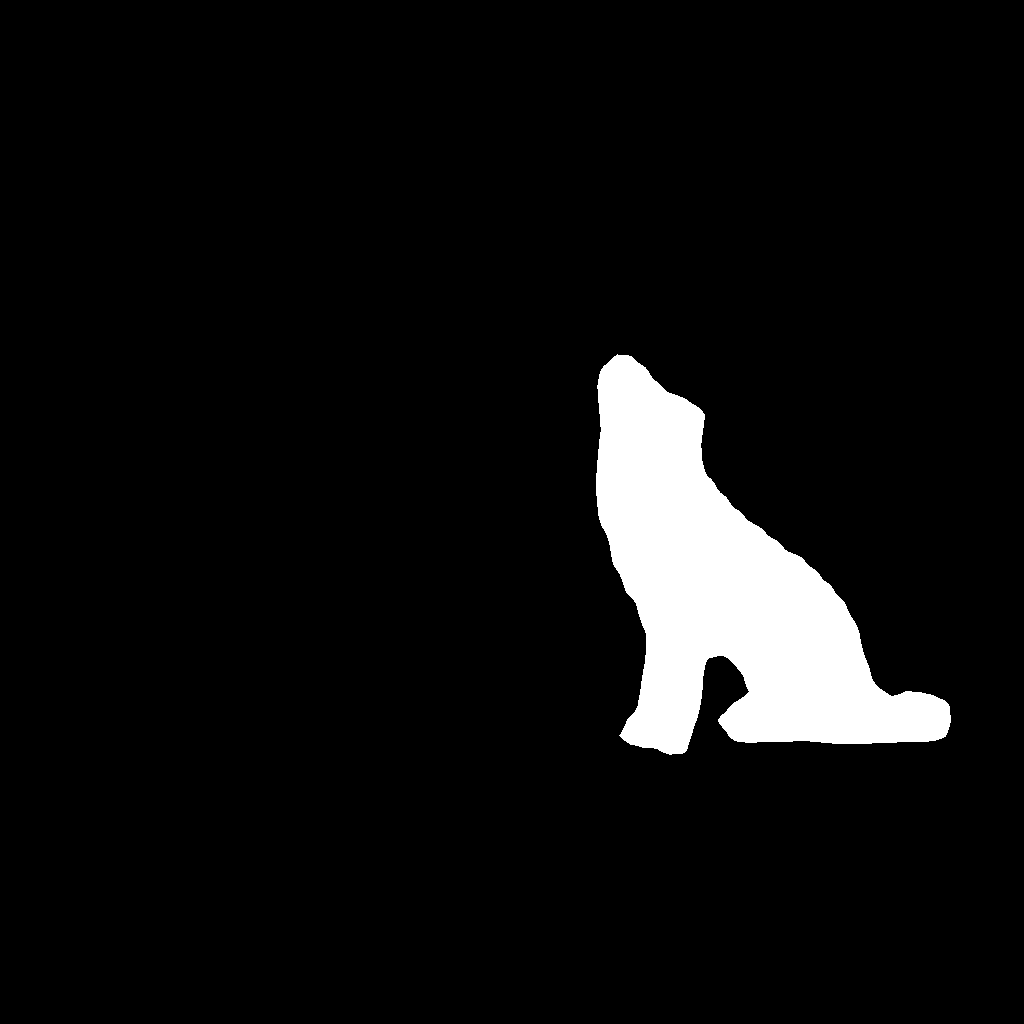

In [8]:
detectron2_bmask = Image.fromarray(binary_mask)
detectron2_bmask

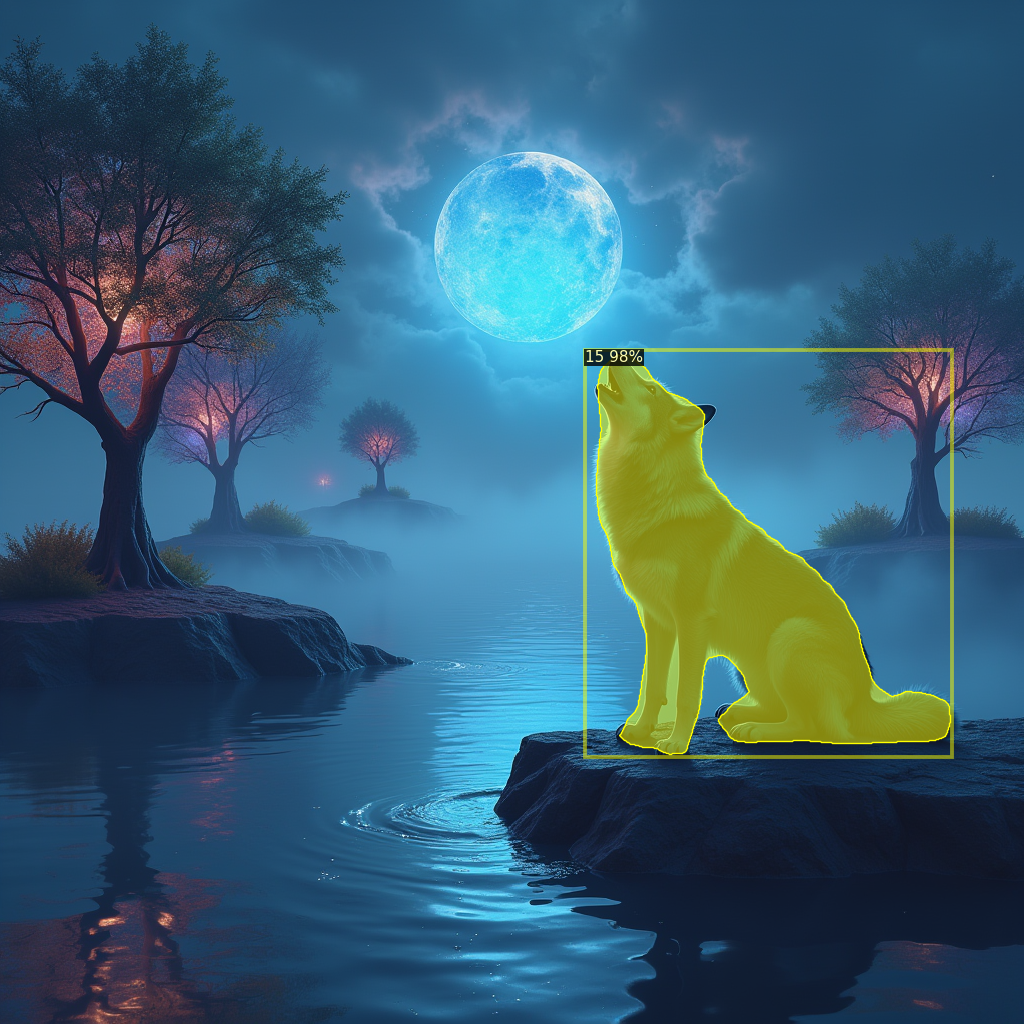

In [9]:
detectron2_output = Image.fromarray(out.get_image())
detectron2_output

In [10]:
if check_image_existance('Image Refining/Binary Masks/Detectron2/', image_name + '_bmask'):
    detectron2_bmask.save(f'Image Refining/Binary Masks/Detectron2/{image_name}_bmask.png')

In [11]:
if check_image_existance('Image Refining/Binary Masks/Detectron2/', image_name + '_output'):
    detectron2_output.save(f'Image Refining/Binary Masks/Detectron2/{image_name}_output.png')

### 3.2 Masked RCNN Resnet50

In [12]:
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

/home/kostasbouros/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kostasbouros/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [13]:
image_tensor = F.to_tensor(init_image)
image_tensor = image_tensor.unsqueeze(0)

with torch.no_grad():
    prediction = model(image_tensor)

masks = prediction[0]['masks'].squeeze().cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

Number of masks generated with 55% acc:  2


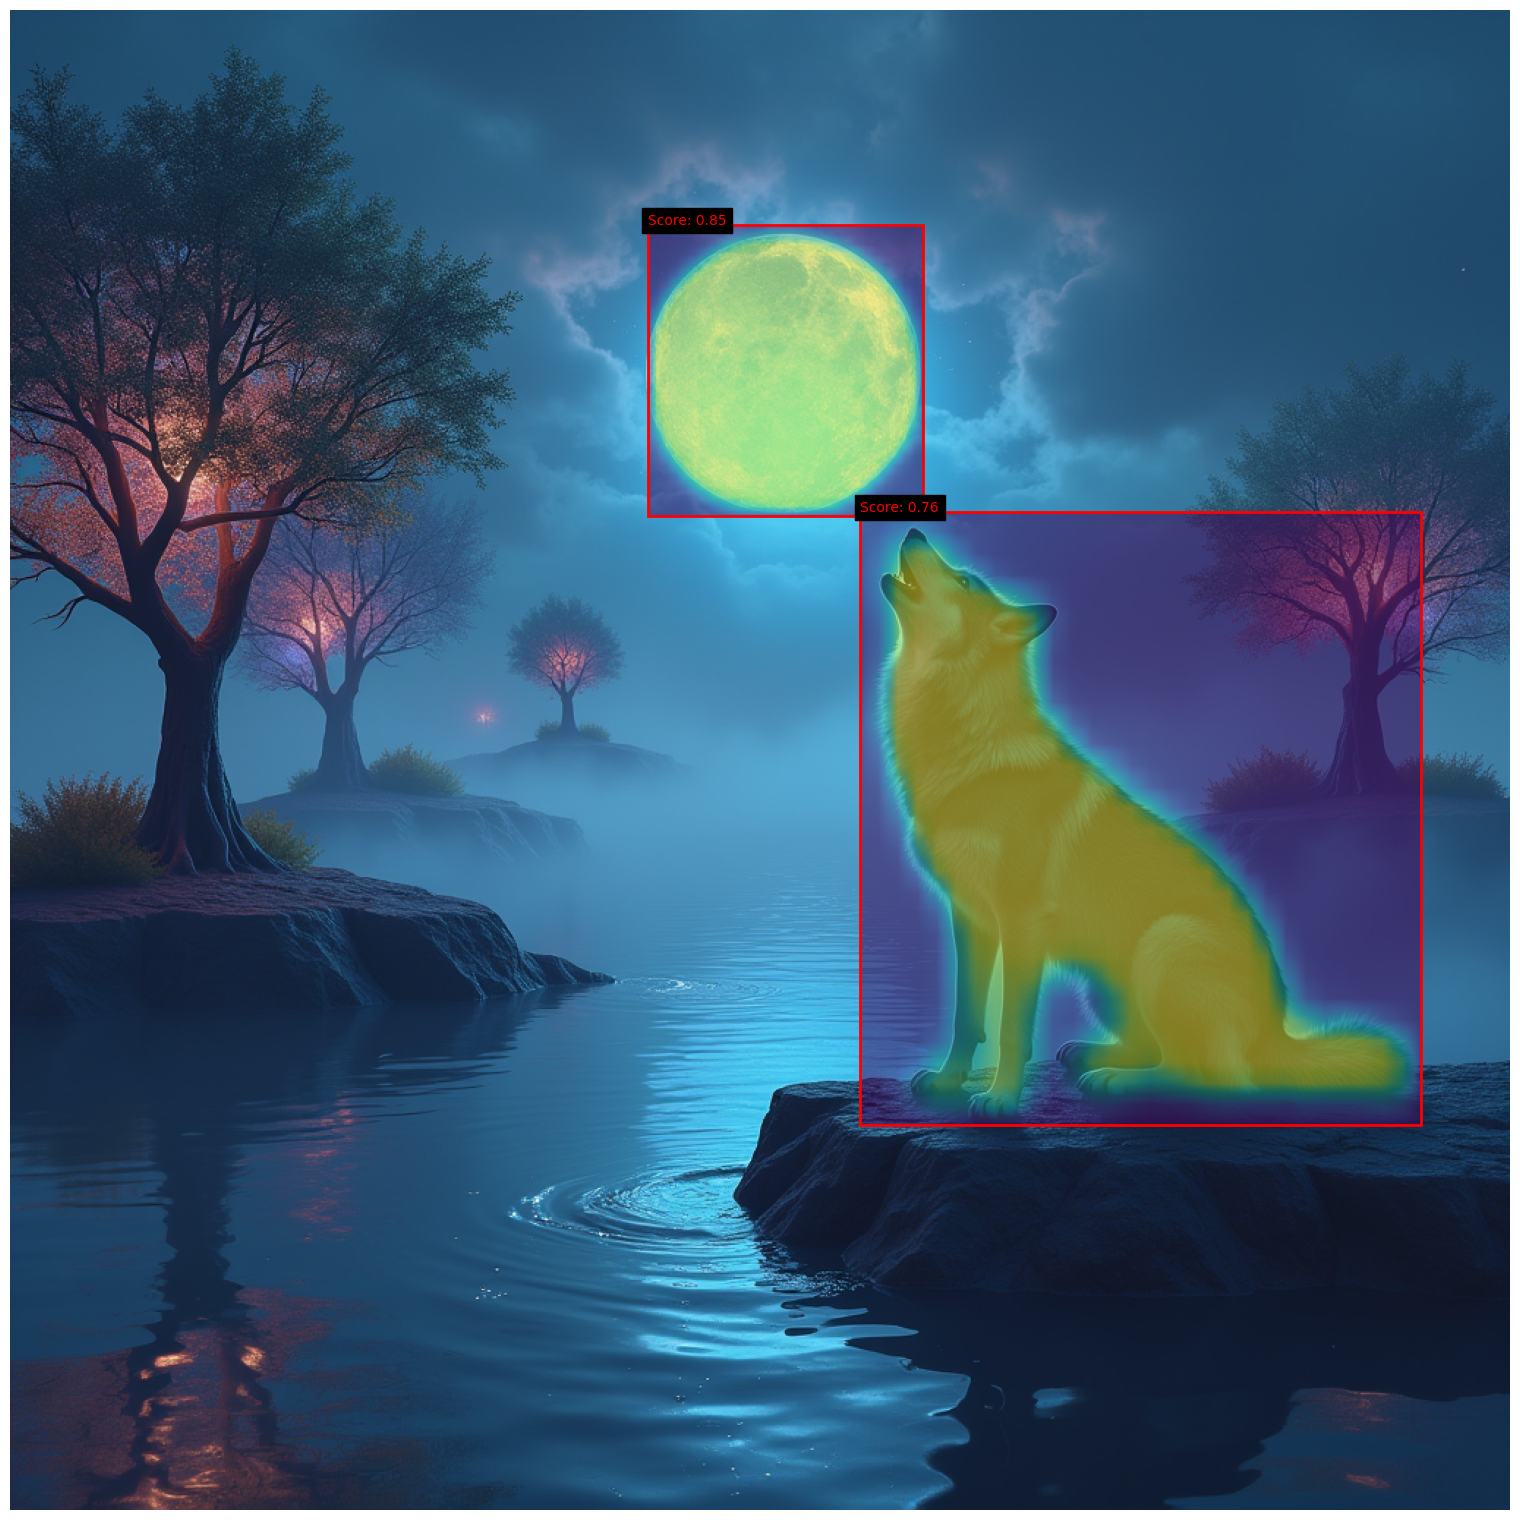

In [14]:
plt.figure(figsize=(15, 15))
plt.imshow(init_image)

# Filter scores and masks above the threshold
threshold = 0.55
filtered_indices = np.where(scores > threshold)[0]  # Get indices of scores above the threshold
count_masks = len(filtered_indices)  # Count of masks with accuracy above 55%
print('Number of masks generated with 55% acc: ', count_masks)

# Set the bounding box color and a list to save the masks
color = 'red'
total_masks = []

# Iterate over all masks that meet the threshold criteria
for i, idx in enumerate(filtered_indices):
    mask = masks[idx]
    score = scores[idx]

    # Automatically detect the bounding box coordinates from the mask
    non_zero_indices = np.where(mask > 0)

    # If there are non-zero pixels in the mask, proceed
    
    y_min, y_max = np.min(non_zero_indices[0]), np.max(non_zero_indices[0])
    x_min, x_max = np.min(non_zero_indices[1]), np.max(non_zero_indices[1])

    # Create the mask for the current score and overlay it
    masked = np.ma.masked_where(mask == 0, mask)
    plt.imshow(masked, alpha=0.5)

    # Add the bounding box outline (without filling it)
    bbox_coords = [x_min, y_min, x_max - x_min, y_max - y_min]  # Automatically calculated coordinates
    rect = plt.Rectangle(
        (x_min, y_min),
        bbox_coords[2],
        bbox_coords[3],
        linewidth=2,
        edgecolor=color,
        facecolor='none'
    )
    plt.gca().add_patch(rect)

    # Display the score at the top-left corner outside the box
    plt.text(
        x_min,
        y_min,
        f'Score: {score:.2f}',
        color=color,
        backgroundcolor='black',
        fontsize=10
    )

    total_masks.append(Image.fromarray((mask * 255).astype('uint8'), mode='L'))

# Hide axis and show the final plot
plt.axis(False)

# Adjust padding to remove white spaces
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Save the image without white padding
if check_image_existance('Image Refining/Binary Masks/Mask RCNN Resnet50/', image_name + '_output'):
    plt.savefig(
        f'Image Refining/Binary Masks/Mask RCNN Resnet50/{image_name}_output.png',
        bbox_inches='tight',
        pad_inches=0
    )

plt.show()

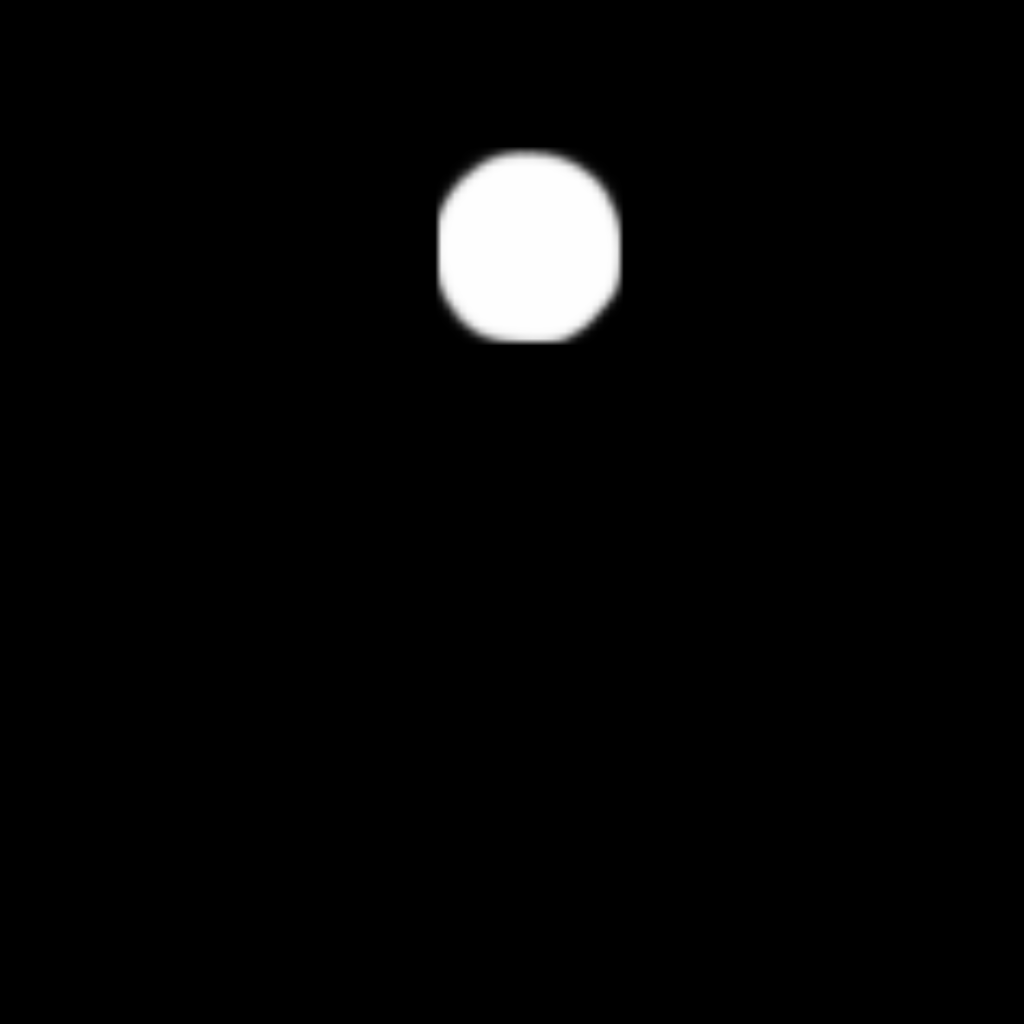

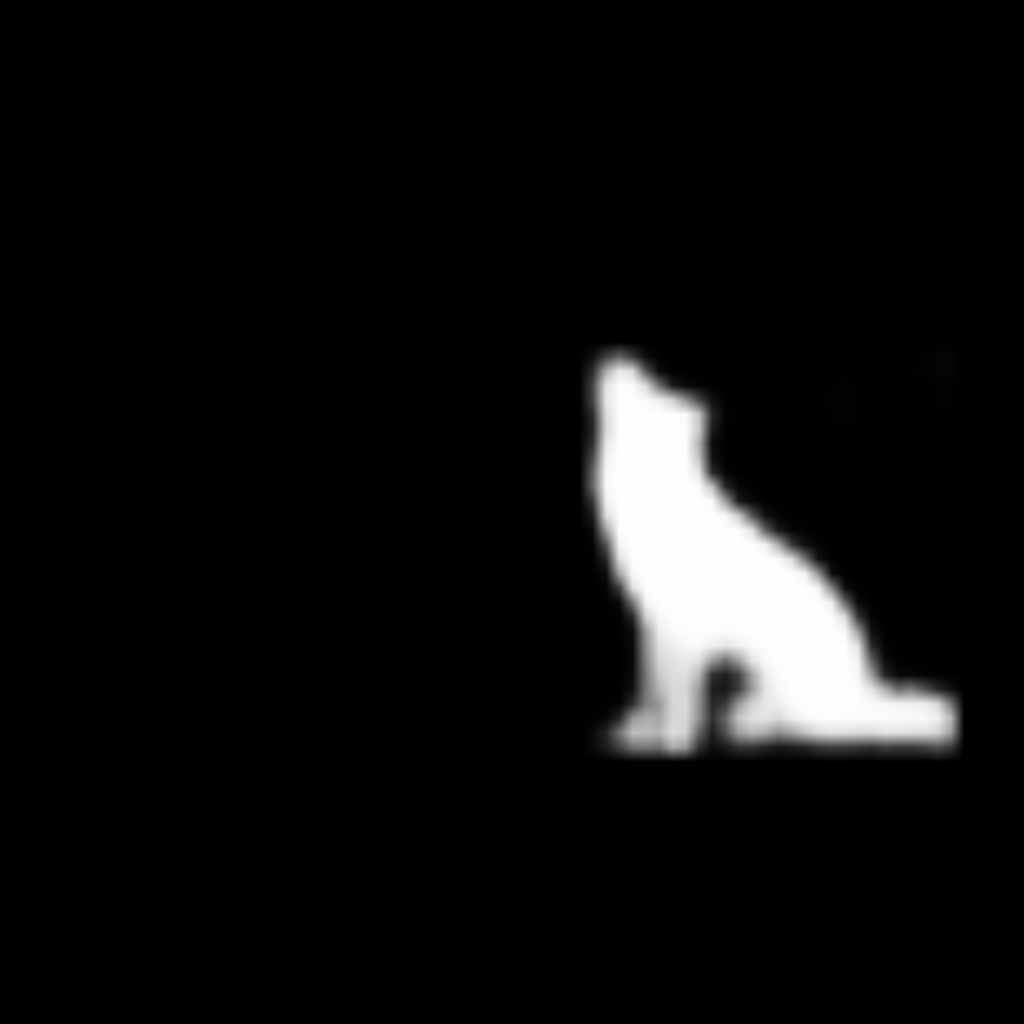

In [15]:
for i, mask in enumerate(total_masks):
    mask.show()
    if check_image_existance('Image Refining/Binary Masks/Mask RCNN Resnet50/', image_name + f'_bmask_{i}'):
        mask.save(f'Image Refining/Binary Masks/Mask RCNN Resnet50/{image_name}_bmask_{i}.png')

## 4. Image Upscaling

### 4.1 AuraSR V2

In [16]:
aura_sr = AuraSR.from_pretrained("fal/AuraSR-v2")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
upscaled_image = aura_sr.upscale_4x_overlapped(init_image)
upscaled_image.size

(4096, 4096)

In [18]:
upscaled_image.save(f'Image Refining/Upscaling/AuraSR V2/{image_name}.png')

### 4.2 Flux.1 Controlnet

In [7]:
# from diffusers import FluxControlNetPipeline
# from diffusers import FluxControlNetModel

# controlnet = FluxControlNetModel.from_pretrained(
#   "jasperai/Flux.1-dev-Controlnet-Upscaler",
#   torch_dtype=torch.bfloat16
# )

# pipe = FluxControlNetPipeline.from_pretrained(
#   "black-forest-labs/FLUX.1-dev",
#   controlnet=controlnet,
#   torch_dtype=torch.bfloat16
# )

# pipe.to("cuda")

## 5. Image Inpainting

### 5.1 Kandinsky 2

In [5]:
pipe = AutoPipelineForInpainting.from_pretrained("kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16).to('cuda')
# pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
prompt = "A white wolf sitting in the rock and howling"

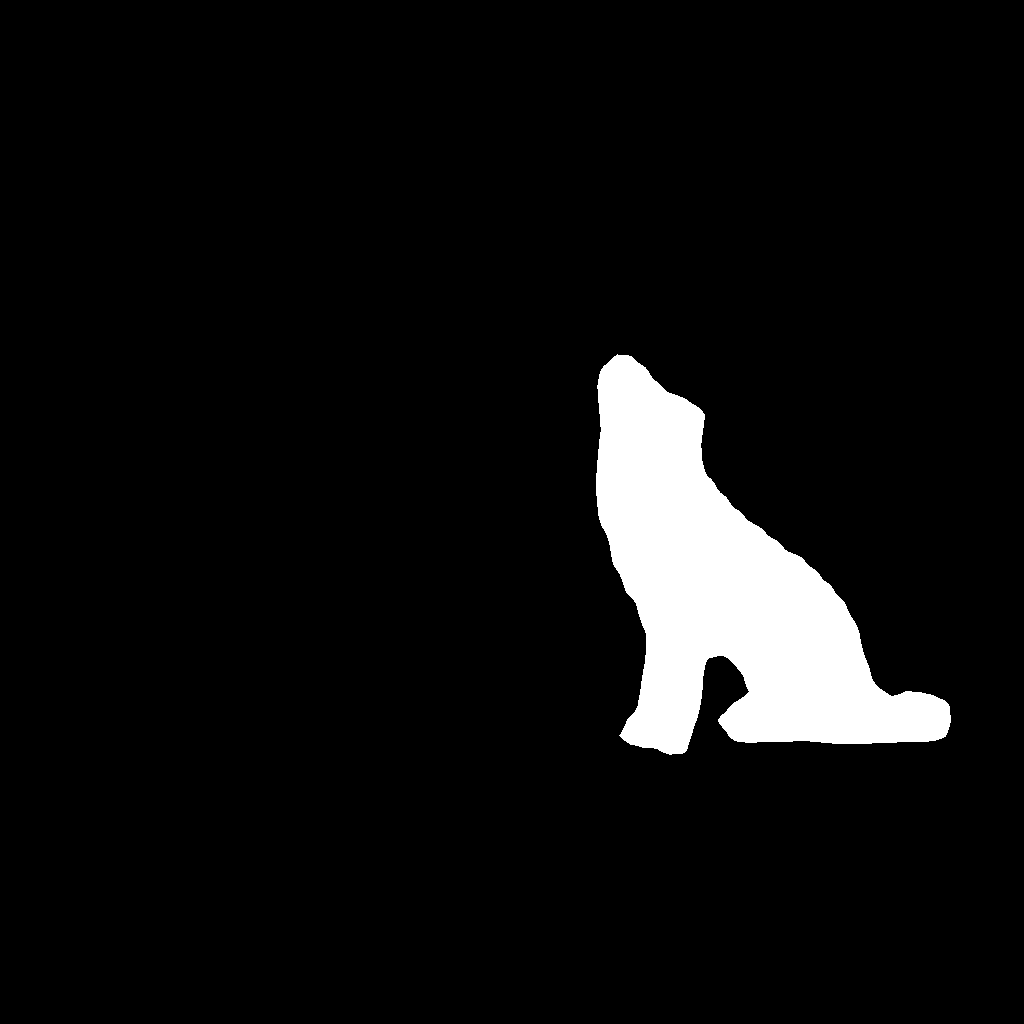

In [18]:
mask = Image.open('Image Refining/Binary Masks/Detectron2/' + image_name + '_bmask.png')
mask

In [19]:
image = pipe(
    prompt=prompt,
    image=init_image,
    mask_image=mask,
    height=768,
    width=768,
    num_inference_steps=300,
    guidance_scale=7, 
).images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

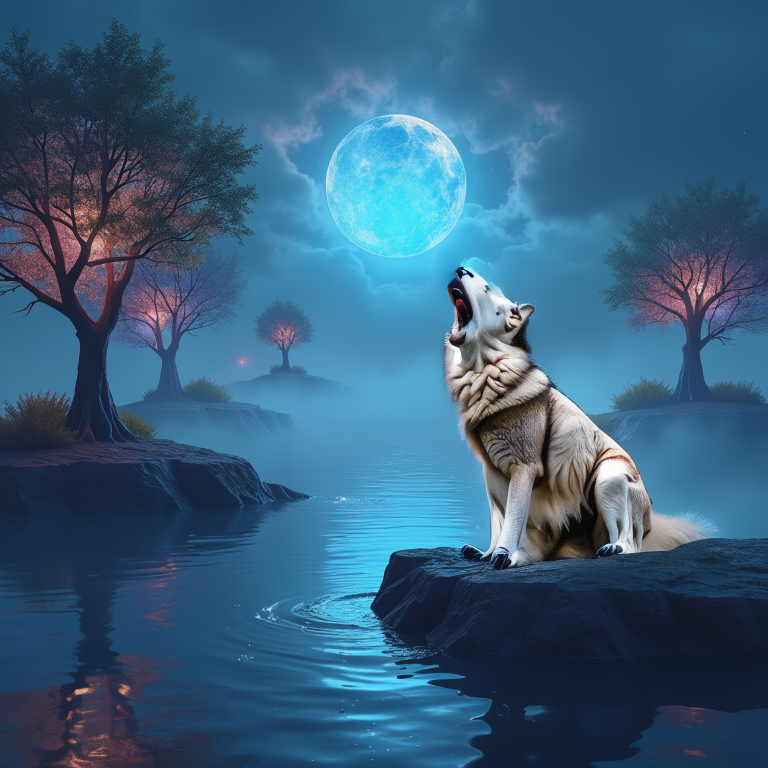

In [20]:
image

In [10]:
max_number = count_files('Image Refining/Inpainting/Kandinsky 2/')

image.save(f'Image Refining/Inpainting/Kandinsky 2/{image_name}_{max_number}.png')

### 5.2 Dreamshaper 8

In [21]:
pipe = AutoPipelineForInpainting.from_pretrained('Lykon/dreamshaper-8-inpainting', torch_dtype=torch.float16, variant="fp16")
pipe.scheduler = DEISMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to('cuda')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/kostasbouros/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.30.3",
  "_name_or_path": "Lykon/dreamshaper-8-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DEISMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [22]:
prompt = "A white fox sitting in the water"
# prompt = ""
# prompt = ""
# prompt = ""
# prompt = ""

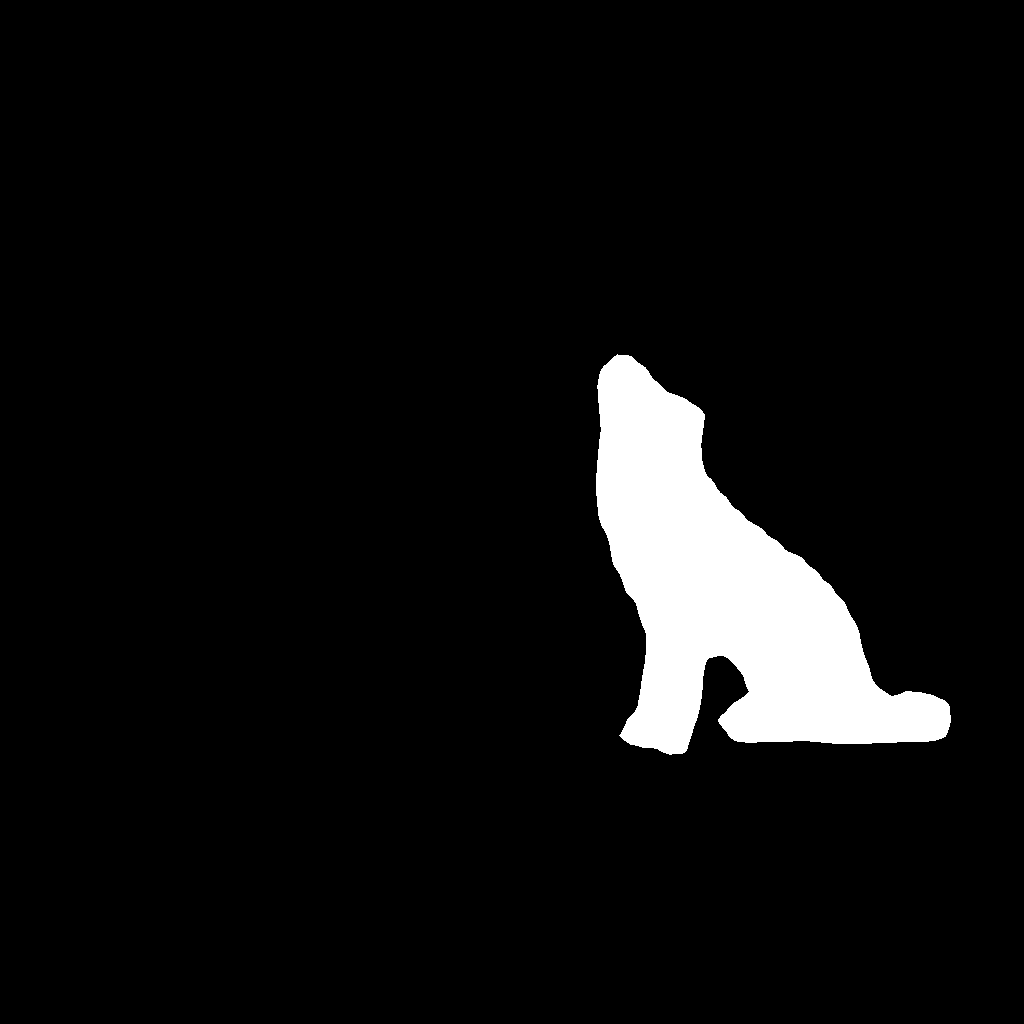

In [23]:
mask = Image.open('Image Refining/Binary Masks/Detectron2/' + image_name + '_bmask.png')
mask

In [35]:
image = pipe(
    prompt=prompt,
    image=init_image,
    mask_image=mask,
    num_inference_steps=400,
    guidance_scale=2,
    clip_skip=0
).images[0]

  0%|          | 0/400 [00:00<?, ?it/s]

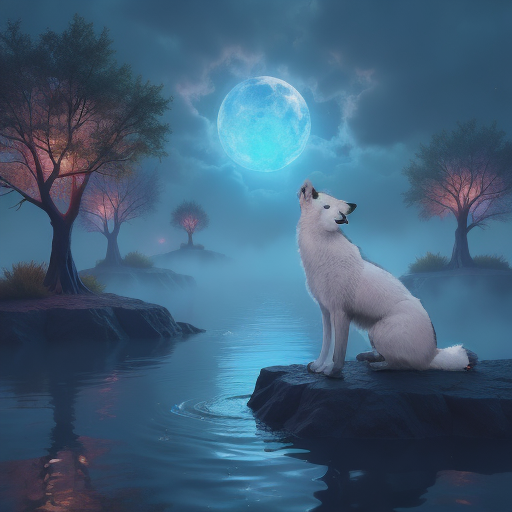

In [36]:
image

In [37]:
max_number = count_files('Image Refining/Inpainting/DreamShaper 8/')
image.save(f'Image Refining/Inpainting/DreamShaper 8/{image_name}_{max_number}.png')